In [ ]:
from torch.utils.data import DataLoader,Dataset,TensorDataset
from torch import nn,optim
import torch
import tqdm

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

device: cuda


In [ ]:
!mkdir data
%cd data

/content/data


## LSTM 및 GRU를 활용한 영화 리뷰 문장 긍정/부정 분류

- 영화 리뷰 문장 분류를 위한 데이터셋

In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar xf aclImdb_v1.tar.gz

--2023-04-30 20:58:54--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  16.3MB/s    in 8.1s    

2023-04-30 20:59:03 (9.86 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



nn.Embedding 예시를 확인해보겠습니다
- 10000 종류의 토큰을 20차원으로
- padding_idx=0 : 토큰 벡터의 idx=0이면 모두 0으로 임베딩
- nn.Embedding의 이름에서 알 수 있듯이 네트워크의 한 종류로 학습이 가능합니다

In [ ]:
emb=nn.Embedding(10000,20,padding_idx=0) 
inp=torch.tensor([1,2,5,2,10,0],dtype=torch.int64)
out=emb(inp)
out

tensor([[-2.7663e-02,  1.9472e+00,  9.0322e-02,  9.4453e-01, -2.3458e-01,
          1.7720e-01,  2.7148e-01,  1.3425e-02,  2.5931e-01,  4.3158e-01,
         -5.9868e-01, -1.0055e+00, -6.6334e-01, -9.0141e-01, -7.9687e-01,
         -1.3586e+00, -7.1854e-01, -4.8467e-01,  5.2425e-01,  1.8859e+00],
        [ 1.1637e+00, -1.0287e-03, -6.9145e-01,  5.2265e-01, -8.5297e-01,
          5.5908e-01,  3.1861e-01,  1.4826e+00,  8.0861e-01,  6.3022e-01,
          1.1790e+00, -3.6179e-01,  1.7516e+00, -9.8788e-01, -3.9252e-01,
         -8.2674e-01, -9.9110e-01, -1.0391e+00,  8.5059e-01,  5.6361e-01],
        [ 8.7866e-01, -1.0495e+00, -1.2442e+00,  1.2687e-01, -7.1679e-01,
         -1.2520e+00,  1.6998e-01, -1.6592e+00, -9.1003e-01, -1.2991e+00,
         -6.2869e-01,  2.0541e-01, -3.3976e-01,  4.6413e-01,  1.8091e+00,
          9.4933e-01,  4.7300e-01,  2.3626e+00,  4.4657e-01,  2.4936e-01],
        [ 1.1637e+00, -1.0287e-03, -6.9145e-01,  5.2265e-01, -8.5297e-01,
          5.5908e-01,  3.1861e-01, 

- 데이터 전처리 과정

In [ ]:
import pathlib
import re

remove_marks_regex=re.compile("[,\.\(\)\[\]\*:;]|<.*?>")
shift_marks_regex=re.compile("([?!])")

def text2ids(text,vocab_dict):
    # 불필요한 문자 삭제
    text=remove_marks_regex.sub("",text)
    # !?와 단어 사이에 공백 삽입
    text=shift_marks_regex.sub(r" \1",text)
    
    tokens=text.split()
    
    return [vocab_dict.get(token,0) for token in tokens]

def list2vector(token_idxes,max_len=100,padding=True):
    if len(token_idxes)>max_len: #문장의 길이를 고정된 토큰 수로 맞추기
        token_idxes=token_idxes[:max_len]
        
    n_tokens=len(token_idxes)
    
    if padding:
        token_idxes=token_idxes+[0]*(max_len-len(token_idxes)) #고정된 토큰 수 맞추기 -> lstm에 input sequence len 일정
        
    return torch.tensor(token_idxes,dtype=torch.int64),n_tokens

- Dataset class를 이용하여 IMDB data를 불러오는 IMDBDataset class를 정의해보겠습니다

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self,dir_path,train=True,max_len=100,padding=True):
        self.max_len=max_len
        self.padding=padding
        
        path=pathlib.Path(dir_path)
        vocab_path=path.joinpath('imdb.vocab') #리뷰에 등장한 모든 단어를 모은 단어 모음집
        
        self.vocab_array=vocab_path.open().read().strip().splitlines()
        self.vocab_dict=dict((w,i+1) for (i,w) in enumerate(self.vocab_array))
        
        if train:
            target_path=path.joinpath('train')
        else:
            target_path=path.joinpath('test')
        
        pos_files=sorted(target_path.joinpath('pos').glob('*.txt'))
        neg_files=sorted(target_path.joinpath('neg').glob('*.txt'))
        #pos=1,neg=0 labeling
        self.labeled_files=list(zip([0]*len(neg_files),neg_files))+list(zip([1]*len(pos_files),pos_files))
        
        
    @property
    def vocab_size(self):
        return len(self.vocab_array)

    def __len__(self):
        return len(self.labeled_files)

    def __getitem__(self,idx):
        label,f= self.labeled_files[idx]
        data=open(f).read().lower()
        '''상위 셀에서 정의한 두 함수의 매개변수와 리턴값을 보고 함수를 작성해주세요'''
        data='____'
        data,n_tokens='_____'

        return data,label,n_tokens

- DataLoader객체를 생성합니다

In [ ]:
train_data=IMDBDataset('./aclImdb/')
test_data=IMDBDataset('./aclImdb/',train=False)

train_loader=DataLoader(train_data,batch_size=32,shuffle=True)
test_loader=DataLoader(test_data,batch_size=32,shuffle=False)

### 모델 class를 정의해보겠습니다

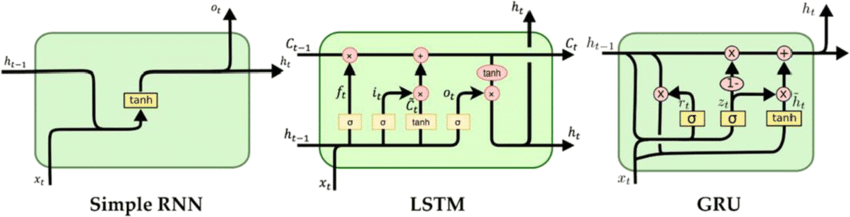

- LSTM은 hidden_state와 cell_state가 존재 -> input에 initial (h0,c0) 필요 (default zero)
  - h0 : (num_direction∗num_layers,Hout) for unbatched input or (num_direction∗num_layers,N,Hout) for batched input
  - c0 : (num_direction∗num_layers,Hcell) for unbatched input or (num_direction∗num_layers,N,Hcell) for batched input
-  GRU는 hidden_state만 존재 -> input에 initial h0만 필요 (default zero)
  - h0 : (num_direction∗num_layers,Hout) for unbatched input or (num_direction∗num_layers,N,Hout) for batched input

In [ ]:
class LSTM_Network(nn.Module):
    def __init__(self,num_embeddings,embedding_dim=50,hidden_size=50,num_layers=1,dropout=0.2,bidirectional=False):
        super().__init__()
        self.emb=nn.Embedding(num_embeddings,embedding_dim,padding_idx=0) #num_embeddings : vocab 모든 단어수
        '''LSTM의 input size가 무엇인지 작성해주세요'''
        self.lstm=nn.LSTM('_________',hidden_size,num_layers,batch_first=True,dropout=dropout,bidirectional=bidirectional)
        #batch_first : input이 (seq_len, batch_size, features)가 아니라 (batch_size, seq_len, features)일 때
        if bidirectional:
          self.linear=nn.Linear(hidden_size*2,1)
        else:
          self.linear=nn.Linear(hidden_size,1)

    def forward(self,x,h0=None,l=None): #h0 : hidden state & cell state init #l : x문장의 토큰 개수
        x=self.emb(x)
        x,h=self.lstm(x,h0)

        if l is not None:
            x=x[list(range(len(x))),l-1,:]
        else:
            x=x[:,-1,:]
            
        x=self.linear(x)
        x=x.squeeze()
        return x

In [ ]:
class GRU_Network(nn.Module):
    def __init__(self,num_embeddings,embedding_dim=50,hidden_size=50,num_layers=1,dropout=0.2,bidirectional=False):
        super().__init__()
        self.emb=nn.Embedding(num_embeddings,embedding_dim,padding_idx=0) #num_embeddings : vocab 모든 단어수
        '''GRU의 input size가 무엇인지 작성해주세요(위 문제와 같습니다)'''
        self.gru=nn.GRU('________',hidden_size,num_layers,batch_first=True,dropout=dropout,bidirectional=bidirectional)
        #batch_first : input이 (seq_len, batch_size, features)가 아니라 (batch_size, seq_len, features)일 때
        if bidirectional:
          self.linear=nn.Linear(hidden_size*2,1)
        else:
          self.linear=nn.Linear(hidden_size,1)
        
    def forward(self,x,h0=None,l=None): #x : 1 * 100(문장길이(단어구성수))  #h0 : hidden state & cell state init
        x=self.emb(x)
        x,h=self.gru(x,h0) 

        if l is not None:
            x=x[list(range(len(x))),l-1,:]
        else:
            x=x[:,-1,:]
            
        x=self.linear(x)
        x=x.squeeze()
        return x

In [ ]:
def eval_net(net,data_loader,device='cpu'):
    net.eval()
    ys=[]
    ypreds=[]
    for x,y,l in data_loader:
        x=x.to(device)
        y=y.to(device)
        l=l.to(device)
        with torch.no_grad():
            y_pred=net(x)
            y_pred=(y_pred>0).long() #시그모이드 넣기 전 값
            ys.append(y)
            ypreds.append(y_pred)
    ys=torch.cat(ys)
    ypreds=torch.cat(ypreds)
    
    acc=(ys==ypreds).float().sum()/len(ys)
    return acc.item()

In [ ]:
from statistics import mean

#num_embedding에는 0을 포함하여 vocab_size+1 넣는다
net=LSTM_Network(train_data.vocab_size+1,num_layers=2)

#다른 모델 예시입니다.
#net=LSTM_Network(train_data.vocab_size+1,num_layers=2,bidirectional=True)
#net=GRU_Network(train_data.vocab_size+1,num_layers=2)

net.to(device)

opt=optim.Adam(net.parameters())
loss_f=nn.BCEWithLogitsLoss()

for epoch in range(10):
    losses=[]
    net.train()
    
    for x,y,l in tqdm.tqdm(train_loader):
        x=x.to(device)
        y=y.to(device)
        l=l.to(device)
        
        y_pred=net(x,l=l)

        loss=loss_f(y_pred,y.float())

        net.zero_grad()
        #net.zero_grad()는 모델의 모든 가중치를 optimizer.zero_grad()는 학습할 가중치를 대상으로 합니다 -> 별 차이 없습니다

        '''역전파 및 가중치 갱신 코드를 작성해주세요'''
        '_____________'
        '_____________'

        losses.append(loss.item())
        
    train_acc=eval_net(net,train_loader,device)
    val_acc=eval_net(net,test_loader,device)
    print(epoch,mean(losses),train_acc,val_acc)

100%|██████████| 782/782 [00:08<00:00, 88.45it/s]


0 0.6543616180682121 0.6739599704742432 0.6498799920082092


100%|██████████| 782/782 [00:09<00:00, 78.79it/s]


1 0.5260921815395965 0.7989599704742432 0.7446399927139282


100%|██████████| 782/782 [00:09<00:00, 84.84it/s]


2 0.46587446328166804 0.8438000082969666 0.7639600038528442


100%|██████████| 782/782 [00:09<00:00, 83.92it/s]


3 0.38555145743862745 0.8673999905586243 0.780519962310791


100%|██████████| 782/782 [00:09<00:00, 84.83it/s]


4 0.3413618125135789 0.8990399837493896 0.7822799682617188


100%|██████████| 782/782 [00:09<00:00, 84.26it/s]


5 0.284488262451442 0.9064799547195435 0.7834799885749817


100%|██████████| 782/782 [00:08<00:00, 87.11it/s]


6 0.2470137109251126 0.922279953956604 0.7816399931907654


100%|██████████| 782/782 [00:09<00:00, 83.90it/s]


7 0.20355816866935747 0.9452799558639526 0.7951599955558777


100%|██████████| 782/782 [00:09<00:00, 86.54it/s]


8 0.1734034164041719 0.9570399522781372 0.7911999821662903


100%|██████████| 782/782 [00:09<00:00, 84.59it/s]


9 0.1455333060477777 0.9623199701309204 0.7802000045776367


직접 positive,negative 문장을 가져와서 검증해보겠습니다

In [ ]:
path=pathlib.Path('./aclImdb')
vocab_path=path.joinpath('imdb.vocab')

vocab_array=vocab_path.open().read().strip().splitlines()
vocab_dict=dict((w,i+1) for (i,w) in enumerate(vocab_array))

In [ ]:
pos_test=list(path.joinpath('test/pos').glob('*.txt'))[1]
neg_test=list(path.joinpath('test/neg').glob('*.txt'))[1]

In [ ]:
data=open(pos_test).read().lower()
print(data)
data=text2ids(data,vocab_dict)
data,n_tokens=list2vector(data,max_len=100,padding=True)
data=data.unsqueeze(0)
data=data.to(device)

this film is a joy to watch and should do well on dvd and video. i suppose you really have to be irish to appreciate the some of the subtlties such as accent, colloquialisms and the dress sense of some of the characters but let me assure you that when dylan moran impersonates 'barreler' the impersonation is quite familiar to most people from dublin because we have many characters in our fine city that look, act and talk like that! the sheer simple comedy employed and michael caines genius acting alone are worth the money but on top of this the plot is great, the script is fantastic and the dialogue fast moving and catchy. a perfect light entertainment movie without the madcap humour of jim carrey.


In [ ]:
pred=net(data,l=n_tokens)
print('positive' if pred>0 else 'negative')

positive


In [ ]:
data=open(neg_test).read().lower()
print(data)
data=text2ids(data,vocab_dict)
data,n_tokens=list2vector(data,max_len=100,padding=True)
data=data.unsqueeze(0)
data=data.to(device)

**warning** miserable movie **warning** the day before christmas eve, some nut case decided he'd entertain us by sending this movie as "entertainement" on tv. what in gods name was he thinking?<br /><br />this movie is filled with awful humor, despicable acting, lousy jokes and a disaster of a plot line. randy quaid plays the idiotic role as cousin eddie johnson. eddie is a brain dead person, who's incapable of even the simplest tasks. he was fired because he was dumb as a brick, but the company he worked for was sorry for it so they sent him and his family on a vacation. but being as stupid as he is, he managed to make the vacation into a disaster.<br /><br />all-in-all it's the worst movie i've seen, and i have nightmares still over the miserable acting and the even more miserable jokes in this movie. it's so sad you almost have to see it... but don't. the nightmares i have are far worse than any other nightmares you will ever have. trust me... i hate this movie so bad because of it'

In [ ]:
pred=net(data,l=n_tokens)
print('positive' if pred>0 else 'negative')

negative


## LSTM 및 GRU을 활용한 시계열 예측

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

- 데이터를 불러옵니다

In [ ]:
from google.colab import files
files.upload()

Saving international-airline-passengers.csv to international-airline-passengers.csv


{'international-airline-passengers.csv': b'1949-01,112\n1949-02,118\n1949-03,132\n1949-04,129\n1949-05,121\n1949-06,135\n1949-07,148\n1949-08,148\n1949-09,136\n1949-10,119\n1949-11,104\n1949-12,118\n1950-01,115\n1950-02,126\n1950-03,141\n1950-04,135\n1950-05,125\n1950-06,149\n1950-07,170\n1950-08,170\n1950-09,158\n1950-10,133\n1950-11,114\n1950-12,140\n1951-01,145\n1951-02,150\n1951-03,178\n1951-04,163\n1951-05,172\n1951-06,178\n1951-07,199\n1951-08,199\n1951-09,184\n1951-10,162\n1951-11,146\n1951-12,166\n1952-01,171\n1952-02,180\n1952-03,193\n1952-04,181\n1952-05,183\n1952-06,218\n1952-07,230\n1952-08,242\n1952-09,209\n1952-10,191\n1952-11,172\n1952-12,194\n1953-01,196\n1953-02,196\n1953-03,236\n1953-04,235\n1953-05,229\n1953-06,243\n1953-07,264\n1953-08,272\n1953-09,237\n1953-10,211\n1953-11,180\n1953-12,201\n1954-01,204\n1954-02,188\n1954-03,235\n1954-04,227\n1954-05,234\n1954-06,264\n1954-07,302\n1954-08,293\n1954-09,259\n1954-10,229\n1954-11,203\n1954-12,229\n1955-01,242\n1955-02,

In [ ]:
data=pd.read_csv('international-airline-passengers.csv',index_col=0,header=None)

- 데이터 개형을 살펴봅니다

<Axes: xlabel='0'>

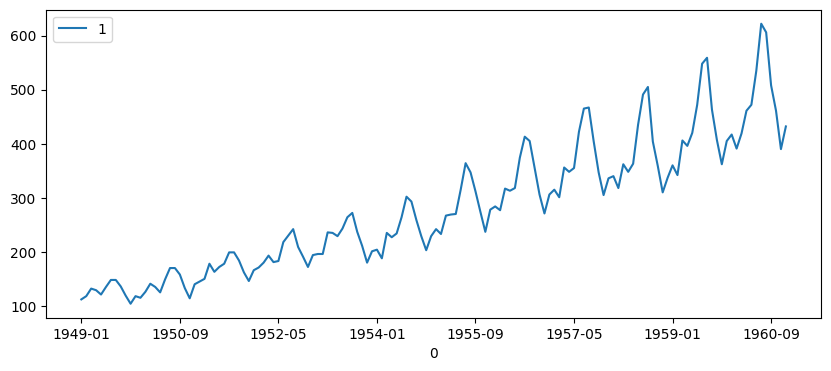

In [ ]:
data.plot(figsize=(10,4))

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
scaled_data=scaler.fit_transform(data)

- 시계열 데이터를 input으로 넣기 위해서는 데이터를 window크기로 slicing하여 3차원으로 만들어야합니다

In [ ]:
def sliding_window(data,seq_length,stride=1): #window 크기 = seq_len
  x=[]
  y=[]

  for i in range(0,len(data)-seq_length-1,stride):
    '''매개변수 seq_length 값을 이용하여 윈도우 슬라이싱 _x와 다음 timestep값인 예측값 _y 코드를 완성해주세요'''
    _x=data['________']
    _y=data['________']
    x.append(_x)
    y.append(_y)

  return np.array(x),np.array(y)

In [ ]:
x_data,y_data=sliding_window(scaled_data,4,1)
print(f'x.shape : {x_data.shape}\ny.shape : {y_data.shape}')

x.shape : (139, 4, 1)
y.shape : (139, 1)


- 총 데이터에서 훈련에 사용할 데이터를 slicing합니다

In [ ]:
train_size=int(len(x_data)*0.7)

x_data = torch.Tensor(x_data)
y_data = torch.Tensor(y_data)

trainX = x_data[0:train_size]
trainY = y_data[0:train_size]

- 이번에는 GRU 모델을 사용해보겠습니다

In [ ]:
class GRU_Network(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers=1):
        super().__init__()
        self.hidden_size=hidden_size
        self.gru=nn.GRU(input_size,hidden_size,num_layers,batch_first=True)
        self.linear=nn.Linear(hidden_size,1)
        
    def forward(self,x,h0=None):
        x,h=self.gru(x,h0)
        out=self.linear(h)
        return out

In [ ]:
lr = 0.01
num_epoch=1000

net=GRU_Network(input_size=1,hidden_size=2)
net.to(device)

opt=optim.Adam(net.parameters(),lr=lr)
loss_f=nn.MSELoss()

- 학습을 시작해보겠습니다. 데이터가 많지 않으므로 전체 데이터를 한꺼번에 학습하겠습니다.

In [ ]:
train_hist=[]
trainX=trainX.to(device)
trainY=trainY.to(device)
net.train()

for epoch in range(num_epoch):
  
  y_pred=net(trainX)

  loss=loss_f(y_pred,trainY)
  opt.zero_grad()

  loss.backward()
  opt.step()

  train_hist.append(loss.item())
  if epoch%10==0:
    print(epoch,loss.item())

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([97, 1])) that is different to the input size (torch.Size([1, 97, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 0.45814040303230286
10 0.22273877263069153
20 0.12092641741037369
30 0.07146287709474564
40 0.04381676763296127
50 0.028649603947997093
60 0.02148870937526226
70 0.01889139600098133
80 0.018190810456871986
90 0.01783975400030613
100 0.017367465421557426
110 0.016797661781311035
120 0.016174225136637688
130 0.01547797117382288
140 0.014683110639452934
150 0.013775711879134178
160 0.012744497507810593
170 0.011580352671444416
180 0.010284525342285633
190 0.008877670392394066
200 0.007411354221403599
210 0.0059797149151563644
220 0.004717825911939144
230 0.0037657557986676693
240 0.0031928368844091892
250 0.0029370002448558807
260 0.002847298514097929
270 0.0028010981623083353
280 0.0027552288956940174
290 0.00270879571326077
300 0.0026652293745428324
310 0.0026244455948472023
320 0.002585568930953741
330 0.002548226621001959
340 0.00251233228482306
350 0.0024778221268206835
360 0.0024446146562695503
370 0.0024126318749040365
380 0.002381806029006839
390 0.002352082869037986
400 0.00232

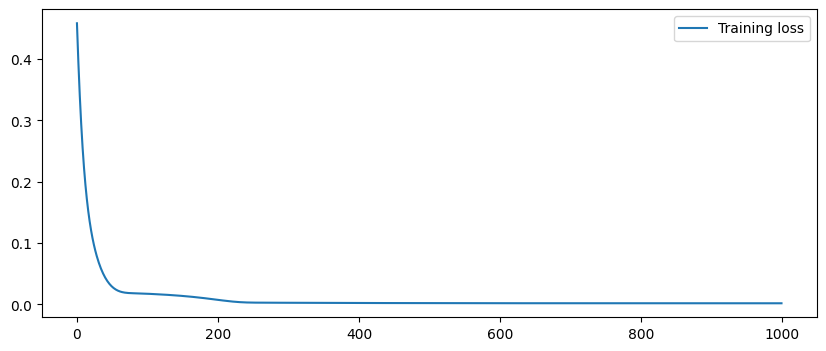

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

- 훈련시킨 모델로 예측을 시도하고 예측값들을 스케일링 하기 이전의 스케일 값으로 되돌려 비교해보겠습니다.

In [ ]:
preds=net(x_data.to(device))
preds=preds.to('cpu')

#inverse
'''사전에 진행한 스케일링을 inverse 시켜서 원본 스케일로 변환시켜주세요(inverse_transform())'''
preds_inverse = '___________'
y_inverse = '__________'

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(preds_inverse, y_inverse))

MAE SCORE :  25.640174833588677


- 최종 예측 결과로 빨간 선 이후로는 학습에 사용되지 않은 예측 결과입니다.

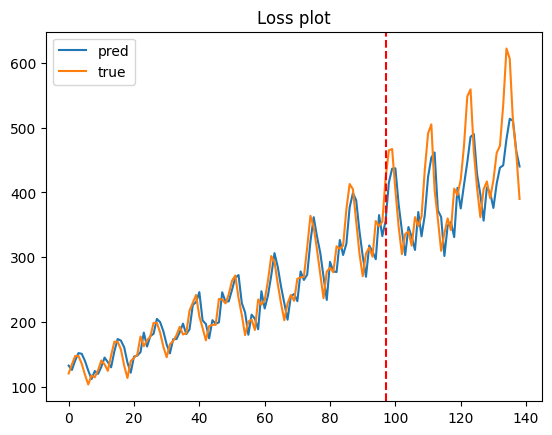

In [ ]:
plt.plot(np.arange(len(preds_inverse)), preds_inverse, label = 'pred')
plt.plot(np.arange(len(y_inverse)), y_inverse, label = 'true')
plt.axvline(x=train_size,c='r',linestyle='--')
plt.legend()
plt.title("Loss plot")
plt.show()

## 1년 동안의 동아리 활동 고생 많으셨습니다. 컨퍼런스까지 모두 잘 마치시길 바랍니다 !